In [3]:
#Llamamos a las librerias que vamos a necesitar
import spacy
import pathlib
import pandas as pd
from collections import Counter
from spacy import displacy
from spacy.matcher import Matcher
import altair as alt
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import es_core_news_sm
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [4]:
# cargar un modelo
nlp = spacy.load("es_core_news_sm")

In [5]:
datos = pd.read_csv('../results/all_amazon_reviews.csv')
print(datos.head(2))

         asin         star_rating                                  title  \
0  B0CJNQBKX9  5.0 de 5 estrellas  EXCELENTE NITIDEZ Y CALIDAD DE IMAGEN   
1  B0CJNQBKX9  5.0 de 5 estrellas                     Excelente producto   

                                         review_text  
0  Me fascino por la versatilidad de sus contrast...  
1  Excelente calidad de imagenMe gustó mucho la m...  


In [6]:
datos['review_text'] = datos['review_text'].fillna('') 
datos['doc'] = datos['review_text'].apply(lambda x: nlp(x) if isinstance(x, str) else '')

In [7]:
comentarios_por_asin = datos.groupby('asin')['review_text'].apply(lambda x: ' '.join(x)).reset_index()

# Contar el número de comentarios por 'asin'
conteo_por_asin = datos['asin'].value_counts().reset_index()
conteo_por_asin.columns = ['asin', 'conteo']

# Crear una gráfica de barras con Altair
grafica = alt.Chart(conteo_por_asin).mark_bar(
    color='steelblue',  # Color de las barras
    size=30  # Ancho de las barras
).encode(
    x='asin:N',
    y='conteo:Q',
    tooltip=['asin:N', 'conteo:Q']
).properties(
    title='Número de comentarios por ASIN'
)

# Mostrar la gráfica
grafica

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [8]:
# Procesar los textos con spaCy y agregar los resultados a la columna 'doc'
datos['doc'] = datos['review_text'].apply(lambda x: nlp(x) if isinstance(x, str) else [])

In [9]:
df_filtered = datos[datos['review_text'].apply(lambda x: x is not None and x != '' and x != '()')]

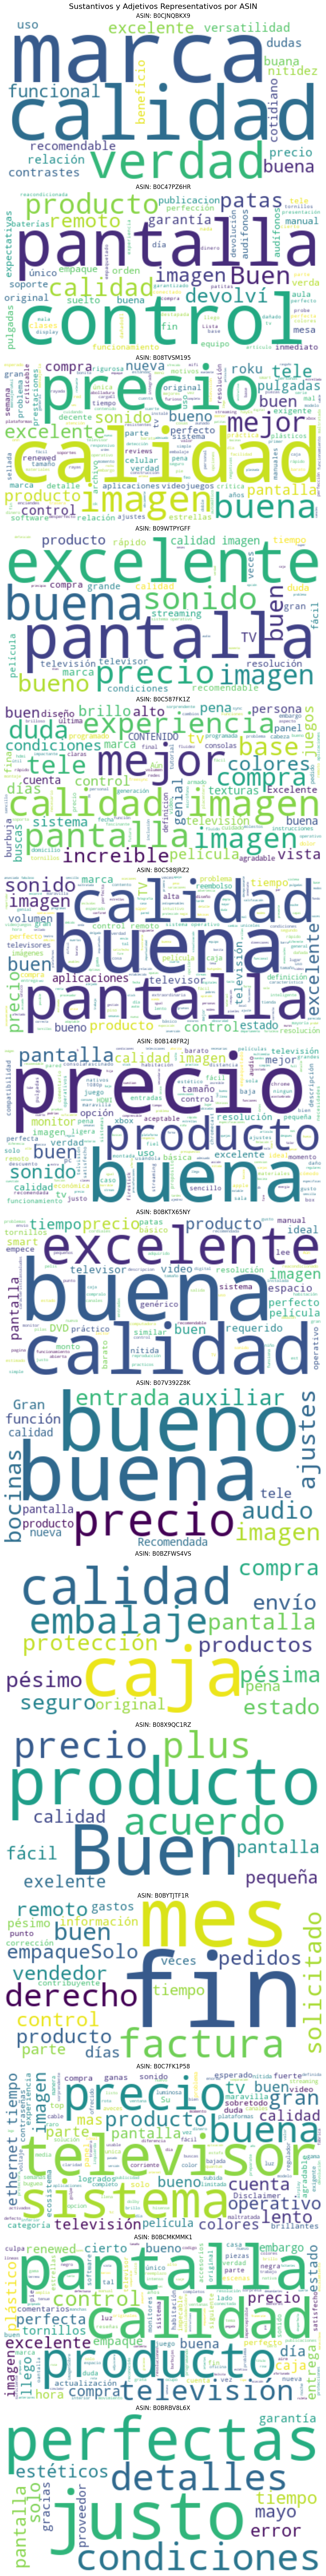

In [10]:


# Crear una función para extraer sustantivos y adjetivos representativos por ASIN
def obtener_sustantivos_adjetivos_representativos(df, asin):
    comentarios = ' '.join(df[df['asin'] == asin]['review_text'])
    doc = nlp(comentarios)
    sustantivos_adjetivos_representativos = [token.text for token in doc if token.pos_ in ('NOUN', 'ADJ')]
    return sustantivos_adjetivos_representativos

# Obtener una lista de ASIN únicos
asin_unicos = df_filtered['asin'].unique()

# Ajustar el diseño y agregar títulos
fig, axs = plt.subplots(len(asin_unicos), 1, figsize=(15, 5 * len(asin_unicos)), constrained_layout=True)

for i, asin in enumerate(asin_unicos):
    sustantivos_adjetivos_representativos = obtener_sustantivos_adjetivos_representativos(df_filtered, asin)

    # Comprobar si hay palabras para la nube de palabras
    if sustantivos_adjetivos_representativos:
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate(' '.join(sustantivos_adjetivos_representativos))
        axs[i].imshow(wordcloud, interpolation='bilinear')
    else:
        axs[i].text(0.5, 0.5, 'No hay datos suficientes para mostrar', ha='center', va='center')
    
    axs[i].set_title(f'ASIN: {asin}')
    axs[i].axis('off')

# Ajustar el diseño y agregar título
plt.suptitle('Sustantivos y Adjetivos Representativos por ASIN', fontsize=16)
plt.show()